# Script de seleção de caracteristicas dos clusters formados nas bases de dados do ENEM

**Autor**: Rafael Victor Araujo Bernardes - rafaelvictor.bernardes@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Variáveis de controle

# ano = '2019'
# ano = '2020'
# ano = '2021'
# ano = '2022'
ano = '2023'

DATASET_ENEM_PATH = 'D:\BASES_PRE_PROCESSADAS\PRE_PROCESSADOS_ENEM_' + ano + '.csv'

In [3]:
microdadosEnem = pd.read_csv(DATASET_ENEM_PATH, sep=',', encoding='ISO-8859-1')

In [4]:
microdadosEnem.shape

(2678264, 169)

In [5]:
microdadosEnem.columns

Index(['MEDIA_NOTAS', 'TP_FAIXA_ETARIA_1', 'TP_FAIXA_ETARIA_2',
       'TP_FAIXA_ETARIA_3', 'TP_FAIXA_ETARIA_4', 'TP_FAIXA_ETARIA_5',
       'TP_FAIXA_ETARIA_6', 'TP_FAIXA_ETARIA_7', 'TP_FAIXA_ETARIA_8',
       'TP_FAIXA_ETARIA_9',
       ...
       'Q024_D', 'Q024_E', 'Q025_A', 'Q025_B', 'MACRO_REGIAO_CENTRO_OESTE',
       'MACRO_REGIAO_NORDESTE', 'MACRO_REGIAO_NORTE', 'MACRO_REGIAO_SUDESTE',
       'MACRO_REGIAO_SUL', 'K_Cluster'],
      dtype='object', length=169)

In [6]:
microdadosEnem.head()

,MEDIA_NOTAS,TP_FAIXA_ETARIA_1,TP_FAIXA_ETARIA_2,TP_FAIXA_ETARIA_3,TP_FAIXA_ETARIA_4,TP_FAIXA_ETARIA_5,TP_FAIXA_ETARIA_6,TP_FAIXA_ETARIA_7,TP_FAIXA_ETARIA_8,TP_FAIXA_ETARIA_9,...,Q024_D,Q024_E,Q025_A,Q025_B,MACRO_REGIAO_CENTRO_OESTE,MACRO_REGIAO_NORDESTE,MACRO_REGIAO_NORTE,MACRO_REGIAO_SUDESTE,MACRO_REGIAO_SUL,K_Cluster
0,507.94,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,3
1,564.28,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,0
2,425.38,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,0
3,617.12,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,3
4,697.66,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,False,False,3


# Métodos para seleção de caracteristicas

https://medium.com/@daython3/mastering-the-art-of-feature-selection-python-techniques-for-visualizing-feature-importance-cacf406e6b71

## chi2

https://medium.com/@matheusventura/teste-qui-quadrado-a95cb5ba8c66

In [ ]:
from sklearn.feature_selection import chi2

colunas_para_analise = [col for col in microdadosEnem.columns if col != 'MEDIA_NOTAS' and col != 'K_Cluster']

for cluster in np.sort(microdadosEnem.K_Cluster.unique()):
    
    # Criar a coluna de labels binários (1 se é do cluster atual, 0 caso contrário)
    labels_binarias = (microdadosEnem['K_Cluster'] == cluster).astype(int)
    
    # Calcular estatística Chi-Quadrado
    chi2_results = chi2(microdadosEnem[colunas_para_analise].values, labels_binarias)
    chi2_scores = chi2_results[0]
    p_values = chi2_results[1]
    
    # Definir limites mais rigorosos de relevância e significância estatística
    thresh = 80000 # Testes anteriores feitos com: (1gl) 3.84; (2gl) 5.99 (4gl) 10.83 (6gl) 12.59 (7gl) 14.07
    pval_thresh = 0.01 # Testes anteriores feitos com: (default) 0.05 (rigoroso) 0.01
    
    # Selecionar características relevantes e estatisticamente significativas
    mask = (chi2_scores >= thresh) & (p_values <= pval_thresh)
    relevant_features = pd.Index(colunas_para_analise)[mask]
    relevant_scores = chi2_scores[mask]
    
    # Combinar características e suas pontuações em um DataFrame e ordenar
    relevant_df = pd.DataFrame({'Feature': relevant_features, 'Chi2 Score': relevant_scores})
    relevant_df = relevant_df.sort_values(by='Chi2 Score', ascending=False)
    
    # Exibir resultados para o cluster atual
    print()
    print(f"============ Características mais relevantes para o Cluster {cluster} ============")
    print()
    for _, row in relevant_df.iterrows():
        print(f"{cluster:d};{row['Feature']};{row['Chi2 Score']:.2f}")

## Seleção Univariada com SelectKBest e f_classif

Avalia a correlação linear entre cada característica e a variável alvo: Cluster analisado

### Determinando o melhor número de K para descrever a base

In [7]:
from sklearn.model_selection import train_test_split

colunas_para_analise = [col for col in microdadosEnem.columns if col not in ['MEDIA_NOTAS', 'K_Cluster']]

Xtrain, Xval, Ytrain, Yval = train_test_split(microdadosEnem[colunas_para_analise], microdadosEnem['K_Cluster'], train_size=0.5, random_state=72769)
Xtrain.shape, Xval.shape, Ytrain.shape, Yval.shape

((1339132, 167), (1339132, 167), (1339132,), (1339132,))

In [8]:
microdadosEnem[colunas_para_analise].shape[1]

167

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

k_vs_score = []
for k in range(1, microdadosEnem[colunas_para_analise].shape[1] + 1, 8):
    
    selector = SelectKBest(score_func=f_classif, k=k)
    Xtrain2 = selector.fit_transform(Xtrain, Ytrain)
    Xval2 = selector.transform(Xval)
    
    mdl = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=72769)
    mdl.fit(Xtrain2, Ytrain)
    
    p = mdl.predict(Xval2)
    score = mean_absolute_error(Yval, p )
    
    print(f"{k:d};{score:.2f}")
    k_vs_score.append(score)

1;1.22
9;0.35
17;0.22
25;0.16
33;0.15
41;0.12
49;0.11
57;0.09
65;0.09
73;0.08
81;0.07
89;0.06
97;0.06
105;0.06
113;0.06
121;0.06
129;0.06
137;0.06
145;0.06
153;0.06
161;0.06


ValueError: x and y must have same first dimension, but have shapes (9,) and (21,)

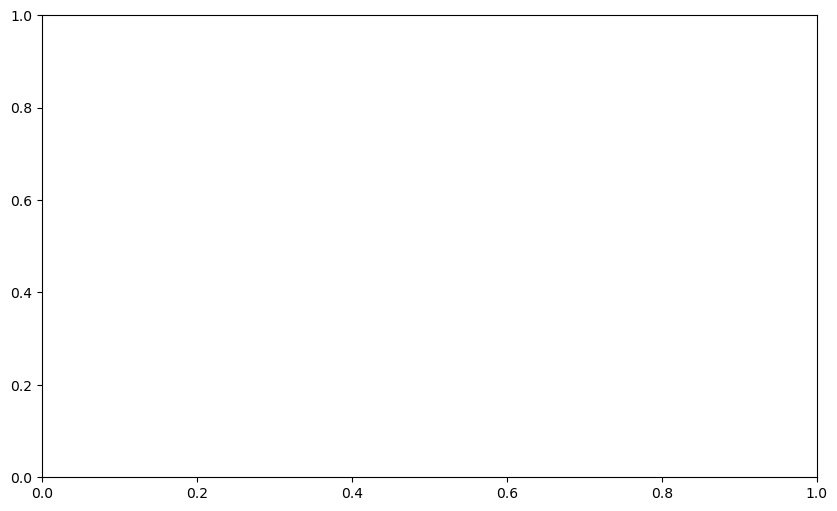

In [13]:
# Plotar a soma dos scores F para diferentes valores de k
plt.figure(figsize=(10, 6))
plt.plot(range(1, microdadosEnem[colunas_para_analise].shape[1] + 1, 20), k_vs_score, marker='o')
plt.xlabel('Número de Características (k)')
plt.ylabel('Soma dos Scores F')
plt.title('Seleção de k Melhor para a Base de Dados')
plt.show()

In [ ]:
colunas_para_analise = [col for col in microdadosEnem.columns if col != 'MEDIA_NOTAS' and col != 'K_Cluster']

for cluster in np.sort(microdadosEnem.K_Cluster.unique()):
    labels_binarias = (microdadosEnem['K_Cluster'] == cluster).astype(int)
    
    k_best = 10
    selector = SelectKBest(score_func=f_classif, k=k_best)
    selector.fit(microdadosEnem[colunas_para_analise], labels_binarias)
    
    # Obter as pontuações F e p-valores
    f_scores = selector.scores_
    p_values = selector.pvalues_
    
    thresh = np.percentile(f_scores, 75)
    pval_thresh = 0.01
    
    # Selecionar características relevantes e estatisticamente significativas
    mask = (f_scores >= thresh) & (p_values <= pval_thresh)
    relevant_features = pd.Index(colunas_para_analise)[mask]
    relevant_scores = f_scores[mask]
    
    # Combinar características e suas pontuações em um DataFrame e ordenar
    relevant_df = pd.DataFrame({'Feature': relevant_features, 'F Score': relevant_scores})
    relevant_df = relevant_df.sort_values(by='F Score', ascending=False)
    
    print()
    print(f"============ Características mais relevantes para o Cluster {cluster} ============")
    print()
    for _, row in relevant_df.iterrows():
        print(f"{cluster:d};{row['Feature']};{row['F Score']:.2f}")


## RandomForestClassifier

Avaliam a importância das características com base na redução da impureza (Gini ou Entropia).

[ABORTADO] - Muito tempo de processamento

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# for cluster in np.sort(microdadosEnem.K_Cluster.unique()):
#     labels_binarias = (microdadosEnem['K_Cluster'] == cluster).astype(int)
    
#     rf = RandomForestClassifier(n_estimators=100, random_state=72769)
#     rf.fit(microdadosEnem[colunas_para_analise].values, labels_binarias)
    
#     importances = rf.feature_importances_
#     relevant_features = pd.Index(colunas_para_analise)[importances > 0]
#     relevant_importances = importances[importances > 0]
    
#     relevant_df = pd.DataFrame({'Feature': relevant_features, 'Importance': relevant_importances})
#     relevant_df = relevant_df.sort_values(by='Importance', ascending=False)
    
#     print()
#     print(f"============ Características mais relevantes para o Cluster {cluster} ============")
#     print()
#     for _, row in relevant_df.iterrows():
#         print(f"{cluster:d};{row['Feature']};{row['Importance']:.4f}")

## Seleção de Características com Lasso

Penaliza características menos importantes, forçando seus coeficientes para zero.

In [ ]:
from sklearn.linear_model import Lasso

for cluster in np.sort(microdadosEnem.K_Cluster.unique()):
    labels_binarias = (microdadosEnem['K_Cluster'] == cluster).astype(int)
    
    lasso = Lasso(alpha=0.01, max_iter=10000)
    lasso.fit(microdadosEnem[colunas_para_analise].values, labels_binarias)
    
    relevant_features = pd.Index(colunas_para_analise)[lasso.coef_ != 0]
    relevant_coefs = lasso.coef_[lasso.coef_ != 0]
    
    relevant_df = pd.DataFrame({'Feature': relevant_features, 'Coefficient': relevant_coefs})
    relevant_df = relevant_df.sort_values(by='Coefficient', ascending=False)
    
    print()
    print(f"============ Características mais relevantes para o Cluster {cluster} ============")
    print()
    for _, row in relevant_df.iterrows():
        print(f"{cluster:d};{row['Feature']};{row['Coefficient']:.4f}")


## PCA (Principal Component Analysis):

Reduz a dimensionalidade dos dados, identificando as componentes principais.

In [ ]:
from sklearn.decomposition import PCA

for cluster in np.sort(microdadosEnem.K_Cluster.unique()):
    # Filtrar dados do cluster atual
    cluster_data = microdadosEnem[microdadosEnem['K_Cluster'] == cluster][colunas_para_analise]
    
    # Aplicar PCA
    pca = PCA(n_components=0.95)  # Manter componentes que explicam 95% da variância
    pca.fit(cluster_data)
    
    # Obter componentes principais
    pca_components = pca.components_
    
    # Obter a importância das características originais em cada componente principal
    feature_importance = np.abs(pca_components).sum(axis=0)
    feature_importance /= feature_importance.sum()

    relevant_features = pd.Index(colunas_para_analise)
    relevant_importance = feature_importance
    
    relevant_df = pd.DataFrame({'Feature': relevant_features, 'Importance': relevant_importance})
    relevant_df = relevant_df.sort_values(by='Importance', ascending=False)

    print()
    print(f"============ Características mais relevantes para o Cluster {cluster} ============")
    print()
    for _, row in relevant_df.iterrows():
        print(f"{cluster:d};{row['Feature']};{row['Importance']:.4f}")